In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import datetime

C:\Users\Vance He\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import data
data = pd.read_csv("C:/Users/Vance He/Desktop/UMich/2020_WN/STATS507/project/project/data/processed_data/one_hot_truncated.csv",
                        parse_dates=['appl_sbm_tm'])

In [3]:
data.head()

,appl_sbm_tm,target,spt_id_card_x,phone_exist_x,auth_time_year,auth_time_month,auth_time_day,birthday,credit_score,overdraft,...,account_grade_3rd Level,account_grade_Initial Level,account_grade_Premier Level,account_grade_unknown,China Mobile,China Telecom,China Unicom,Other,missing_phone,appl_tm_num
0,2017-04-08 19:10:13,0,1,1,2017,3,5,1992-06-15,394.0,0.00,...,0,0,0,1,1,0,0,0,0,376
1,2016-06-08 15:20:21,0,1,1,2016,1,31,0,578.0,2647.14,...,0,0,0,1,1,0,0,0,0,72
2,2016-04-27 11:36:27,0,1,1,2017,6,18,1978-06-25,402.0,0.00,...,1,0,0,0,1,0,0,0,0,30
3,2017-03-30 08:45:55,0,0,1,0,0,0,1987-01-09,579.0,15125.00,...,0,0,0,1,0,0,1,0,0,366
4,2016-11-30 11:40:38,0,1,1,2017,12,15,1985-12-08,390.0,0.00,...,0,0,0,1,1,0,0,0,0,247


In [4]:
# split the training set and the testing set
train_set = data[data['appl_sbm_tm'] < datetime.datetime(2017,3,30)]
test_set = data[data['appl_sbm_tm'] >= datetime.datetime(2017,3,30)]
#train_data_set = train_set[(train_set.year <= 2017) & (train_set.month <= 5)]
#valid_data_set = train_set[(train_set.year >= 2016) & (train_set.month > 5)]

test_set = test_set.drop(['appl_sbm_tm'], axis=1)
train_set = train_set.drop(['appl_sbm_tm'], axis=1)
#train_data_set = train_data_set.drop(['appl_sbm_tm'], axis=1)
#valid_data_set = valid_data_set.drop(['appl_sbm_tm'], axis=1)

test_set = test_set.drop(['birthday'], axis=1)
train_set = train_set.drop(['birthday'], axis=1)
#train_data_set = train_data_set.drop(['birthday'], axis=1)
#valid_data_set = valid_data_set.drop(['birthday'], axis=1)

In [5]:
x_train = train_set.drop(['target'], axis=1)
#x_train = train_data_set.drop(['target'], axis=1)
#x_valid = valid_data_set.drop(['target'], axis=1)
x_test = test_set.drop(['target'], axis=1)

In [6]:
# standardize data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
#x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

In [7]:
y_train = train_set.iloc[:, 0]

In [8]:
y_test = test_set.iloc[:, 0]

In [48]:
y_test.head()

0     0
3     0
6     0
14    0
16    0
Name: target, dtype: int64

In [39]:
x_train.shape

(87174, 111)

In [9]:
y_train = torch.Tensor(y_train.values)

In [83]:
# model paramters
epochs = 20
batch_size = 128
learning_rate = 0.005

In [84]:
# define custom dataloaders
class trainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)
    
train_data = trainData(torch.FloatTensor(x_train),
                      torch.FloatTensor(y_train))

class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
    
    def __len__(self):
        return len(self.X_data)
    
test_data = testData(torch.FloatTensor(x_test))

In [85]:
# intialize dataloader
train_loader = DataLoader(dataset=train_data, 
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [29]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        
        # number of input fetures is 111
        self.layer_1 = nn.Linear(111, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

In [13]:
# check do we have gpu avaliable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [42]:
# intialize optimizer and decide on which loss function to use
model = binaryClassification()
model.to(device)

print(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

binaryClassification(
  (layer_1): Linear(in_features=111, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Train the model

In [19]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [44]:
model.train()
for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print(f'Epoch {e+0:03}: | Loss:{epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss:0.17085 | Acc: 95.343
Epoch 002: | Loss:0.11174 | Acc: 97.097
Epoch 003: | Loss:0.10868 | Acc: 97.096
Epoch 004: | Loss:0.10679 | Acc: 97.102
Epoch 005: | Loss:0.10505 | Acc: 97.106
Epoch 006: | Loss:0.10352 | Acc: 97.100
Epoch 007: | Loss:0.10259 | Acc: 97.095
Epoch 008: | Loss:0.10106 | Acc: 97.106
Epoch 009: | Loss:0.09994 | Acc: 97.097
Epoch 010: | Loss:0.09837 | Acc: 97.109
Epoch 011: | Loss:0.09731 | Acc: 97.087
Epoch 012: | Loss:0.09574 | Acc: 97.116
Epoch 013: | Loss:0.09454 | Acc: 97.126
Epoch 014: | Loss:0.09316 | Acc: 97.123
Epoch 015: | Loss:0.09251 | Acc: 97.142
Epoch 016: | Loss:0.09120 | Acc: 97.112
Epoch 017: | Loss:0.09006 | Acc: 97.170
Epoch 018: | Loss:0.08918 | Acc: 97.189
Epoch 019: | Loss:0.08745 | Acc: 97.184
Epoch 020: | Loss:0.08655 | Acc: 97.218
Epoch 021: | Loss:0.08701 | Acc: 97.189
Epoch 022: | Loss:0.08541 | Acc: 97.262
Epoch 023: | Loss:0.08509 | Acc: 97.238
Epoch 024: | Loss:0.08376 | Acc: 97.237
Epoch 025: | Loss:0.08263 | Acc: 97.305


In [51]:
# Test the model
y_pred_list = []

model.eval()
with torch.no_grad():
    for x_batch in test_loader:
        x_batch = x_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [53]:
confusion_matrix(y_test, y_pred_list)

array([[32715,    65],
       [  968,     7]], dtype=int64)

<Figure size 432x288 with 0 Axes>

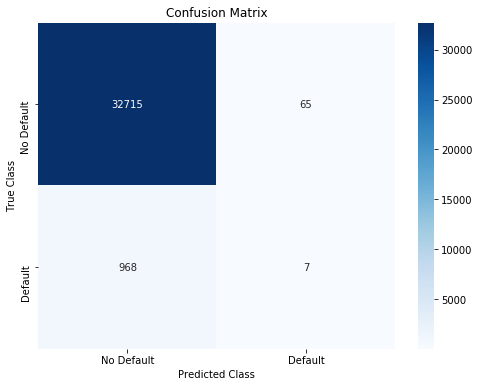

In [54]:
# confusion matrix
plt.figure()
cm = confusion_matrix(test_set['target'],y_pred_list)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [55]:
# classification report
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     32780
           1       0.10      0.01      0.01       975

    accuracy                           0.97     33755
   macro avg       0.53      0.50      0.50     33755
weighted avg       0.95      0.97      0.96     33755



#### Assign weight

In [64]:
data[data['target']==0].shape

(117541, 114)

In [65]:
data[data['target']==1].shape

(3388, 114)

In [30]:
# intialize optimizer and decide on which loss function to use
model = binaryClassification()
model.to(device)

print(model)
weight = torch.Tensor([(117541 / 3388)]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=weight)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

binaryClassification(
  (layer_1): Linear(in_features=111, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Train the model

In [82]:
model.train()
for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print(f'Epoch {e+0:03}: | Loss:{epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss:1.11412 | Acc: 62.991
Epoch 002: | Loss:1.00543 | Acc: 68.855
Epoch 003: | Loss:0.96732 | Acc: 69.903
Epoch 004: | Loss:0.95249 | Acc: 71.161
Epoch 005: | Loss:0.92880 | Acc: 71.731
Epoch 006: | Loss:0.90608 | Acc: 72.078
Epoch 007: | Loss:0.88819 | Acc: 73.078
Epoch 008: | Loss:0.86829 | Acc: 73.481
Epoch 009: | Loss:0.85657 | Acc: 74.188
Epoch 010: | Loss:0.83918 | Acc: 74.468
Epoch 011: | Loss:0.81722 | Acc: 75.255
Epoch 012: | Loss:0.80577 | Acc: 75.484
Epoch 013: | Loss:0.78241 | Acc: 76.380
Epoch 014: | Loss:0.76632 | Acc: 76.902
Epoch 015: | Loss:0.75887 | Acc: 77.214
Epoch 016: | Loss:0.74959 | Acc: 77.492
Epoch 017: | Loss:0.73006 | Acc: 78.483
Epoch 018: | Loss:0.73046 | Acc: 78.263
Epoch 019: | Loss:0.70840 | Acc: 78.900
Epoch 020: | Loss:0.71157 | Acc: 78.841
Epoch 021: | Loss:0.69738 | Acc: 79.375
Epoch 022: | Loss:0.69741 | Acc: 79.671
Epoch 023: | Loss:0.68055 | Acc: 80.015
Epoch 024: | Loss:0.67224 | Acc: 80.216
Epoch 025: | Loss:0.66907 | Acc: 80.468


In [93]:
# Test the model
y_pred_list = []
y_prob = []

model.eval()
with torch.no_grad():
    for x_batch in test_loader:
        x_batch = x_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_prob.append(y_test_pred.cpu().numpy())
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<Figure size 432x288 with 0 Axes>

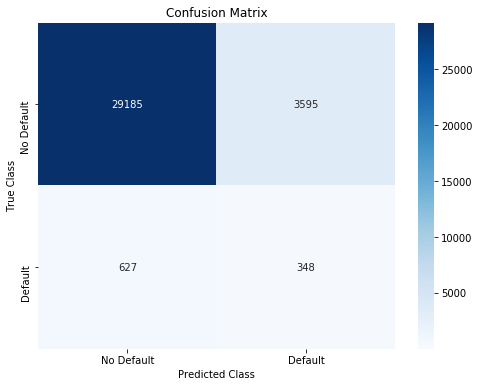

In [84]:
# confusion matrix
plt.figure()
cm = confusion_matrix(test_set['target'],y_pred_list)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [85]:
# classification report
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     32780
           1       0.09      0.36      0.14       975

    accuracy                           0.87     33755
   macro avg       0.53      0.62      0.54     33755
weighted avg       0.95      0.87      0.91     33755



In [103]:
prob = list()
for i in range(len(y_prob)):
    y_prob[i] = y_prob[i][0][0]

In [105]:
print('valid auc', roc_auc_score(y_test, y_prob))

valid auc 0.7467111747313091


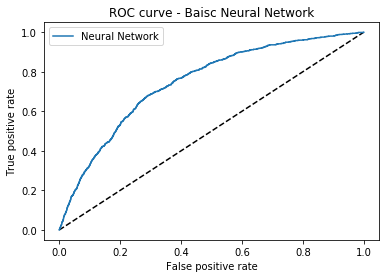

In [109]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob)
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Neural Network')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Baisc Neural Network')
plt.legend(loc='best')
plt.show()

### Optimize Model

In [86]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        
        # number of input fetures is 111
        self.layer_1 = nn.Linear(111, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

In [87]:
# intialize optimizer and decide on which loss function to use
model = binaryClassification()
model.to(device)

print(model)
weight = torch.Tensor([(117541 / 3388)]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=weight)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

binaryClassification(
  (layer_1): Linear(in_features=111, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Train the model

In [88]:
model.train()
for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print(f'Epoch {e+0:03}: | Loss:{epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss:1.10843 | Acc: 64.727
Epoch 002: | Loss:1.02107 | Acc: 67.475
Epoch 003: | Loss:1.00295 | Acc: 69.062
Epoch 004: | Loss:0.97607 | Acc: 68.953
Epoch 005: | Loss:0.94409 | Acc: 70.695
Epoch 006: | Loss:0.93098 | Acc: 71.306
Epoch 007: | Loss:0.90601 | Acc: 72.035
Epoch 008: | Loss:0.88366 | Acc: 72.802
Epoch 009: | Loss:0.88600 | Acc: 73.639
Epoch 010: | Loss:0.85984 | Acc: 73.748
Epoch 011: | Loss:0.82099 | Acc: 74.440
Epoch 012: | Loss:0.81000 | Acc: 74.547
Epoch 013: | Loss:0.79239 | Acc: 74.818
Epoch 014: | Loss:0.81023 | Acc: 76.245
Epoch 015: | Loss:0.76490 | Acc: 76.018
Epoch 016: | Loss:0.72886 | Acc: 77.217
Epoch 017: | Loss:0.70328 | Acc: 78.113
Epoch 018: | Loss:0.70406 | Acc: 78.308
Epoch 019: | Loss:0.68001 | Acc: 79.839
Epoch 020: | Loss:0.66940 | Acc: 79.660


In [89]:
# Test the model
y_pred_list = []
y_prob = []

model.eval()
with torch.no_grad():
    for x_batch in test_loader:
        x_batch = x_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_prob.append(y_test_pred.cpu().numpy())
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<Figure size 432x288 with 0 Axes>

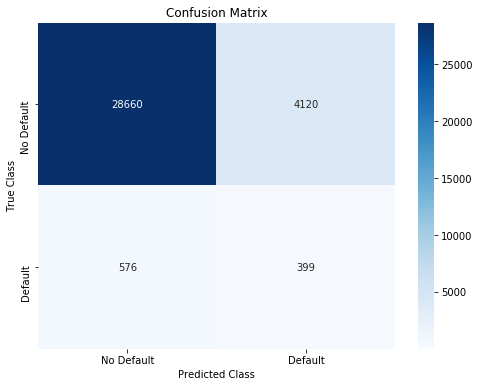

In [90]:
# confusion matrix
plt.figure()
cm = confusion_matrix(test_set['target'],y_pred_list)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [91]:
# classification report
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     32780
           1       0.09      0.41      0.15       975

    accuracy                           0.86     33755
   macro avg       0.53      0.64      0.53     33755
weighted avg       0.95      0.86      0.90     33755



In [92]:
prob = list()
for i in range(len(y_prob)):
    y_prob[i] = y_prob[i][0][0]
print('valid auc', roc_auc_score(y_test, y_prob))

valid auc 0.7608412415325166


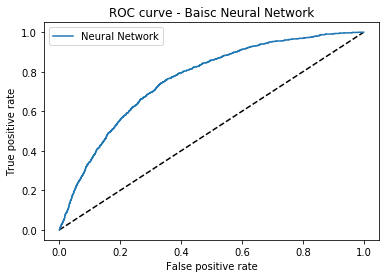

In [93]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob)
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Neural Network')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Baisc Neural Network')
plt.legend(loc='best')
plt.show()